# Explorando la biodivercidad Cundinamarca
- desarrollo del taller 
- Face 1
- Universidad Sergio Arboleda 
- Talento Tech Mintic 
- Participante: **Edisson Giraldo**
- **Bootcamp Inteligencia Artificial**
- Nivel: Explorador
- Tutor: Jhonny Beltran 


## Introducción

El presente proyecto tiene como objetivo principal realizar un análisis exhaustivo de los datos climáticos de la región de Cundinamarca, Colombia. Este análisis se llevará a cabo utilizando diversas técnicas de procesamiento, visualización y modelado de datos para comprender mejor los patrones climáticos, identificar tendencias y proporcionar información útil para la toma de decisiones en diversas áreas, como la agricultura, la planificación urbana y la gestión de riesgos.

### Datos Disponibles

Los datos utilizados en este proyecto provienen de las siguientes fuentes:

- [Datos del Instituto Geográfico Agustín Codazzi (IGAC)](https://www.colombiaenmapas.gov.co/?e=-79.5923887988331,0.6694893523874683,-74.07725208008458,9.068898135000135,4686&b=igac&u=0&t=23&servicio=205)
Base de datos vectorial básica. Colombia. Escala 1:100.000
Entidad: Instituto Geográfico Agustín Codazzi - IGAC
Resumen: 
Cartografía vectorial a escala 1:100.000 con cobertura total de la República de Colombia. 
Contiene información sobre entidades territoriales, transporte terrestre y fluvial, hidrografía, relieve, orografía, construcciones. Se genera a partir de la interpretación de objetos en una imagen ortorectificada provenientes de plataformas satelitales o aerotransportadas.

 - Nivel de detalle: 1:100.000
 - Fecha: 01-04-2022
 - Licencia: CC BY 4.0
- [Datos del Instituto Geográfico Agustín Codazzi (IGAC)](https://www.colombiaenmapas.gov.co/?e=-72.99542931122912,5.621036635365166,-72.8230812887684,5.883380597818378,4686&b=igac&u=0&t=2303&servicio=5&cyear=2019&cescala=1:100.000)
Bases de datos vectoriales por hojas cartográficas
Corresponde a la cartografía básica organizada de acuerdo con el índice definido para cada escala.
- [https://www.datos.gov.co/](https://www.datos.gov.co/Ambiente-y-Desarrollo-Sostenible/Datos-Hidrometeorol-gicos-Crudos-Red-de-Estaciones/sbwg-7ju4/about_data)
Los datos disponibles a través de este medio pueden ser libremente consumidos bajo los siguientes clausulas: 
1. Los datos a visualizar o descargar a continuación no han sido validados por el IDEAM. 
2. Los datos aquí dispuestos son datos crudos instantáneos provenientes de los sensores de las estaciones automáticas de la red propia y/o producto de convenios interadministrativos con terceras entidades. 
3. Los datos son puestos a disposición de la ciudadanía como mecanismo de transparencia y para proveer una herramienta de apoyo a la gestión del riesgo territorial y como datos abiertos en cumplimiento de la Ley 1712 de 2014. 
4. Es posible que los datos aquí dispuestos tengan cierto retraso en el tiempo debido a las frecuencias de envío de datos de los sensores y los medios de transmisión utilizados. 
5. Los datos presenten errores y/o inconsistencias estando incluso por fuera de los límites considerados normales, producto de fallas en los sensores de origen. 
6. El posterior uso e interpretación que se le dé para cualquier finalidad queda bajo la exclusiva responsabilidad del portador de los datos. 
7. Cualquier destino que se le dé a los datos exime al IDEAM de realizarles cualquier tipo de justificación o iniciarles proceso alguno de validación posterior, cuya fuente primaria deben ser los canales oficialmente dispuestos por la Entidad para el suministro de información oficial y validada. 
8. Por las razones expuestas anteriormente los datos dispuestos no podrán ser utilizados como evidencia jurídica ante entes de control acerca de la ocurrencia o no de fenómenos hidroclimatológicos o de soporte a cualquier tipo de situación o evento ocurrido como consecuencia de estos.

Estos conjuntos de datos incluyen información sobre variables climáticas como temperatura, precipitación, humedad, y más, recopilados a través de estaciones meteorológicas distribuidas en la región de Cundinamarca.

### Alcance del Proyecto

El alcance de este proyecto abarca los siguientes aspectos:

1. Extracción y Limpieza de Datos: Se realizará la extracción de datos de las fuentes mencionadas, seguida de una exhaustiva limpieza para garantizar la integridad y calidad de los datos utilizados en el análisis.

2. Análisis Exploratorio de Datos (EDA): Se llevará a cabo un análisis exploratorio de los datos para identificar patrones, tendencias y relaciones entre las variables climáticas.

3. Visualización de Datos: Se utilizarán técnicas de visualización de datos para representar gráficamente la información climática, facilitando su comprensión y análisis.

4. Modelado de Datos: Se explorarán técnicas de modelado de datos para predecir y analizar tendencias climáticas futuras, así como para identificar posibles impactos en diferentes sectores.

5. Generación de Informes y Conclusiones: Se elaborarán informes detallados que resuman los hallazgos del análisis, proporcionando recomendaciones y conclusiones basadas en los resultados obtenidos.

Mediante este proyecto, se espera obtener una comprensión más profunda del clima en la región de Cundinamarca y su impacto en diversas áreas, lo que contribuirá a una mejor toma de decisiones y planificación estratégica en el futuro.


## Extracción de Datos de Socrata y Almacenamiento en Archivos CSV

El siguiente fragmento de código realiza la extracción de datos de Socrata, una plataforma de datos abiertos, utilizando un token de aplicación para la autenticación. Estos datos se filtran por el departamento de Cundinamarca y la fecha de observación a partir del 1 de enero de 2023.

El proceso de extracción se realiza en lotes, donde se especifica un límite de registros por página y un desplazamiento para recorrer todos los datos. Cada lote de datos se guarda en un archivo CSV separado.

El código utiliza la biblioteca `sodapy` para interactuar con la API de Socrata y la biblioteca `pandas` para manejar los datos como un DataFrame. Además, se emplea la biblioteca `dotenv` para cargar las variables de entorno desde un archivo `.env`.

El flujo de trabajo incluye la construcción de una consulta para filtrar los datos deseados, la realización de solicitudes a la API de Socrata, la conversión de los resultados en un DataFrame de Pandas y el almacenamiento de los datos en archivos CSV.

Este proceso se repite hasta que se hayan recuperado todos los datos disponibles que cumplen con los criterios de filtrado especificados.


In [15]:
import os
from dotenv import load_dotenv
import pandas as pd
from sodapy import Socrata

# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Obtener el token de la variable de entorno
app_token = os.getenv("APP_TOKEN")

# Verificar si el token está presente
if not app_token:
    raise ValueError("El token de la aplicación no está definido en el archivo .env")

# Inicializar el cliente Socrata con el app_token
cliente = Socrata('www.datos.gov.co', app_token, timeout=30)

# Definir el tamaño de la página
limit = 50000

# Inicializar el offset
offset = 0

# Contador para el nombre del archivo CSV
csv_count = 1

# Realizar solicitudes de forma repetida hasta que no haya más datos
while True:
    # Construir la consulta con la cláusula where para filtrar los datos desde el año 2020
    consulta = "departamento='CUNDINAMARCA' AND fechaobservacion >= '2023-01-01T00:00:00.000'"

    # Realizar la solicitud con la consulta construida
    result = cliente.get("sbwg-7ju4", where=consulta, limit=limit, offset=offset)

    # Verificar si hay resultados
    if len(result) == 0:
        break
    
    # Convertir los resultados en un DataFrame de Pandas
    df = pd.DataFrame.from_records(result)
    
    # Guardar los datos en un archivo CSV
    csv_filename = f"data_{csv_count}.csv"
    df.to_csv(csv_filename, index=False)
    
    # Incrementar el offset para la próxima solicitud
    offset += limit
    
    # Incrementar el contador de archivos CSV
    csv_count += 1


## Procesamiento y Consolidación de Datos Climáticos

El siguiente fragmento de código realiza la limpieza y consolidación de datos climáticos provenientes de múltiples archivos CSV ubicados en un directorio específico. El proceso de limpieza se lleva a cabo de la siguiente manera:

1. **Carga de archivos CSV**: Itera sobre todos los archivos en el directorio especificado y carga aquellos que tienen extensión ".csv" en un DataFrame individual.

2. **Selección de columnas**: Define las columnas necesarias para el análisis y elimina aquellas que no están presentes en los datos, manteniendo únicamente: 'fechaobservacion', 'valorobservado', 'nombreestacion', 'departamento', 'municipio', 'latitud', 'longitud' y 'descripcionsensor'.

3. **Conversión de tipos de datos**: Convierte la columna 'fechaobservacion' al tipo datetime y la columna 'valorobservado' a tipo numérico. Además, elimina filas que contienen valores faltantes.

4. **Consolidación de datos limpios**: Agrega los datos limpios al DataFrame general `df_all`.

5. **Guardado de datos limpios**: Guarda todos los datos limpios en un archivo CSV llamado 'datos_limpios_total.csv' en el mismo directorio del cuaderno.

Al finalizar el proceso, se imprime un mensaje indicando que la limpieza de datos ha sido completada y que los datos limpios han sido guardados correctamente.


In [11]:
import os
import pandas as pd

# Directorio donde se encuentran los archivos CSV
directorio_csv = "/home/dev1/Documents/sergioarboleda/proyectoClima"

# Inicializar un DataFrame vacío para almacenar todos los datos
df_all = pd.DataFrame()

# Iterar sobre todos los archivos CSV en el directorio
for filename in os.listdir(directorio_csv):
    if filename.endswith(".csv"):
        # Leer el archivo CSV y cargar los datos en un DataFrame
        filepath = os.path.join(directorio_csv, filename)
        df = pd.read_csv(filepath)
        
        # Definir las columnas a mantener
        columnas_mantener = ['fechaobservacion', 'valorobservado', 'nombreestacion', 'departamento',
                             'municipio', 'latitud', 'longitud', 'descripcionsensor']
        
        # Eliminar las columnas que no están presentes en los datos
        columnas_a_eliminar = [col for col in df.columns if col not in columnas_mantener]
        df_clean = df.drop(columns=columnas_a_eliminar)
        
        # Convertir las columnas de fecha a tipo datetime
        df_clean['fechaobservacion'] = pd.to_datetime(df_clean['fechaobservacion'])
        
        # Convertir la columna 'valorobservado' a tipo numérico
        df_clean['valorobservado'] = pd.to_numeric(df_clean['valorobservado'], errors='coerce')
        
        # Eliminar filas con valores faltantes
        df_clean.dropna(inplace=True)
        
        # Agregar los datos limpios al DataFrame general
        df_all = pd.concat([df_all, df_clean], ignore_index=True)

# Guardar todos los datos limpios en un DataFrame en el mismo cuaderno
df_all.to_csv("datos_limpios_total.csv", index=False)

print("Limpieza de datos completada. Los datos limpios se han guardado en 'datos_limpios_total.csv'")



Limpieza de datos completada. Los datos limpios se han guardado en 'datos_limpios_total.csv'


### Exploración de las Columnas del DataFrame

La siguiente instrucción imprime las columnas presentes en el DataFrame `df`. Esta acción permite explorar la estructura de los datos y comprender qué variables están disponibles para su análisis.

Al ejecutar esta línea de código, se obtiene una lista de las columnas del DataFrame, lo que proporciona información sobre las características de los datos cargados y facilita la identificación de las variables relevantes para el análisis posterior.


In [12]:
print(df.columns)

Index(['codigoestacion', 'codigosensor', 'fechaobservacion', 'valorobservado',
       'nombreestacion', 'departamento', 'municipio', 'zonahidrografica',
       'latitud', 'longitud', 'descripcionsensor', 'unidadmedida'],
      dtype='object')


## Análisis exploratorio de datos (EDA): 
Este fragmento de código realiza lo siguiente:

1. **Carga de datos y manejo de valores faltantes**: Lee un archivo CSV llamado "datos_limpios_total.csv" que contiene datos de temperatura. Elimina las filas con valores faltantes.

2. **Análisis de tendencias a lo largo del tiempo**: Convierte la columna 'fechaobservacion' a tipo datetime y crea nuevas columnas 'year' y 'month' para analizar las tendencias de temperatura por año y mes.

3. **Análisis por ubicación geográfica**: Grafica las temperaturas en función de la ubicación geográfica, utilizando la longitud y latitud como coordenadas y el valor observado de temperatura para asignar colores en una escala de color 'coolwarm'.

4. **Identificación de valores atípicos**: Calcula los cuartiles y el rango intercuartílico (IQR) para identificar valores atípicos en la columna 'valorobservado'. Luego imprime los valores atípicos encontrados.

5. **Comparación de temperaturas promedio**: Agrupa los datos por mes y año, calcula la temperatura promedio y grafica la tendencia de la temperatura promedio a lo largo del tiempo.

El código proporciona un análisis exploratorio de datos de temperatura, incluyendo visualizaciones espaciales y temporales, así como la identificación de valores atípicos.


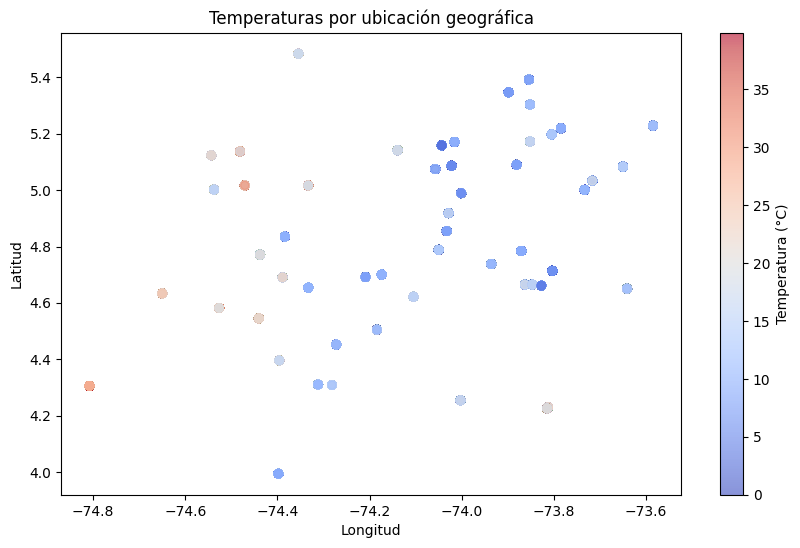

Valores atípicos:
          fechaobservacion  valorobservado               nombreestacion  \
17134  2024-01-06 06:10:00        1.664706                      EL OKAL   
17555  2024-01-06 06:20:00        1.598521                      EL OKAL   
17573  2024-01-06 06:00:00        1.793462                      EL OKAL   
25122  2024-01-09 04:40:00        1.744750                    IBERIA LA   
25195  2024-01-09 05:30:00        1.511817                    IBERIA LA   
...                    ...             ...                          ...   
485478 2023-10-11 10:00:00       32.400000  UNIVERSIDAD DE CUNDINAMARCA   
488225 2023-10-21 12:00:00       33.400000  UNIVERSIDAD DE CUNDINAMARCA   
491579 2023-10-21 11:00:00       32.000000  UNIVERSIDAD DE CUNDINAMARCA   
493130 2023-10-20 15:00:00       31.600000  UNIVERSIDAD DE CUNDINAMARCA   
499637 2023-10-20 10:00:00       32.800000  UNIVERSIDAD DE CUNDINAMARCA   

        departamento   municipio   latitud   longitud  \
17134   CUNDINAMARCA  VI

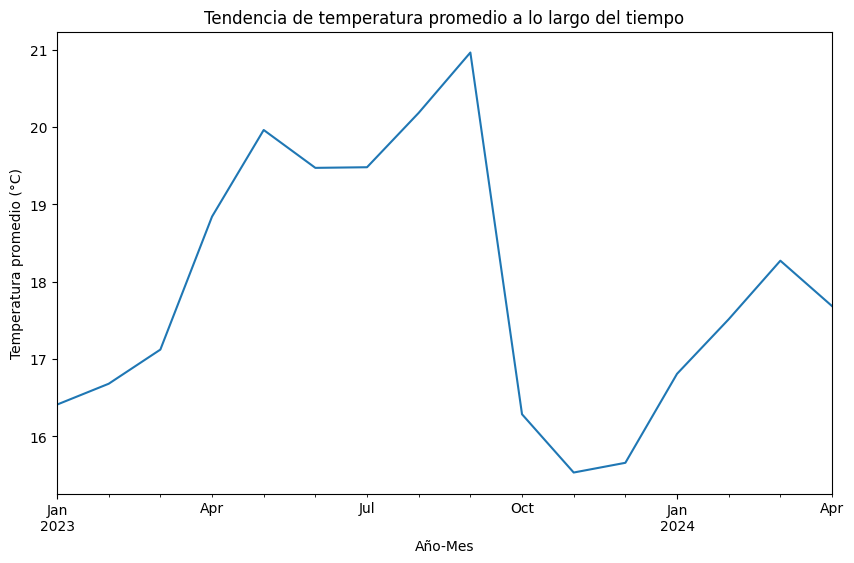

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos limpios desde el archivo CSV
df = pd.read_csv("datos_limpios_total.csv")

# Manejo de datos faltantes
df.dropna(inplace=True)

# Análisis de tendencias a lo largo del tiempo
df['fechaobservacion'] = pd.to_datetime(df['fechaobservacion'])  # Asegurarse de que 'fechaobservacion' es de tipo datetime
df['year'] = df['fechaobservacion'].dt.year
df['month'] = df['fechaobservacion'].dt.month

# Análisis por ubicación geográfica
plt.figure(figsize=(10, 6))
plt.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Temperatura (°C)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Temperaturas por ubicación geográfica')
plt.show()

# Identificación de valores atípicos
Q1 = df['valorobservado'].quantile(0.25)
Q3 = df['valorobservado'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['valorobservado'] < Q1 - 1.5 * IQR) | (df['valorobservado'] > Q3 + 1.5 * IQR)]
print("Valores atípicos:")
print(outliers)

# Comparación de temperaturas promedio
plt.figure(figsize=(10, 6))
df['year_month'] = df['fechaobservacion'].dt.to_period('M')
df.groupby('year_month')['valorobservado'].mean().plot()
plt.xlabel('Año-Mes')
plt.ylabel('Temperatura promedio (°C)')
plt.title('Tendencia de temperatura promedio a lo largo del tiempo')
plt.show()



## Este fragmento de código se encarga de cargar dos conjuntos de datos geoespaciales utilizando la librería GeoPandas y luego visualizarlos utilizando Matplotlib.

`cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp"):` Carga el mapa politico de Cundinamarca desde un archivo Shapefile llamado "MGN_DPTO_POLITICO.shp" ubicado en el directorio `"MGN2021_DPTO_POLITICO"`.

`productos_igac = gpd.read_file("Servicio-93/Proyeccion_2024_2026.shp"):` Carga el mapa cartográficos del IGAC desde un archivo Shapefile llamado "Proyeccion_2024_2026.shp" ubicado en el directorio `"Servicio-93"`.

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el mapa de Cundinamarca
cundinamarca = gpd.read_file("MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp")

# Cargar el cubrimiento de productos cartográficos del IGAC
productos_igac = gpd.read_file("Servicio-93/Proyeccion_2024_2026.shp")

## Estas líneas de código tienen como objetivo obtener información sobre el sistema de referencia de coordenadas (CRS) y los límites espaciales de los conjuntos de datos geoespaciales cargados. Aquí está la explicación de cada una de estas líneas:
1. `print(cundinamarca.crs):` Este comando imprime el CRS (sistema de referencia de coordenadas) del DataFrame geoespacial cundinamarca. El CRS especifica cómo se mapean las coordenadas geográficas a una ubicación en un plano. Esta información es importante para realizar operaciones de análisis espacial y superposición de datos.

2. `print(productos_igac.crs):` Similar al anterior, esta línea imprime el CRS del DataFrame geoespacial productos_igac.

3. `print(cundinamarca.bounds):` Esta línea imprime los límites espaciales del DataFrame geoespacial cundinamarca. Los límites espaciales están definidos por las coordenadas mínimas (minx, miny) y máximas (maxx, maxy) en términos de longitud y latitud del conjunto de datos.

4. `print(productos_igac.bounds):` Similar al anterior, esta línea imprime los límites espaciales del DataFrame geoespacial productos_igac.

El objetivo de imprimir esta información es comprender mejor las características espaciales de los conjuntos de datos cargados y asegurarse de que tengan la misma proyección o que sean compatibles para realizar operaciones de análisis espacial, como superposiciones o visualizaciones conjuntas.

In [15]:
print(cundinamarca.crs)
print(productos_igac.crs)
print(cundinamarca.bounds)
print(productos_igac.bounds)

EPSG:4686
EPSG:9377
         minx       miny       maxx       maxy
0  -77.127832   5.418558 -73.881282   8.873974
1  -75.249527  10.253286 -74.718330  11.105370
2  -74.450850   3.730633 -73.986126   4.837009
3  -76.190631   6.999160 -73.745780  10.801467
4  -74.664960   4.655196 -71.948854   7.055557
5  -75.922510   4.799700 -74.627456   5.779182
6  -76.306221  -0.705840 -71.253846   2.938334
7  -77.928338   0.958028 -75.747824   3.328941
8  -74.139160   7.674350 -72.885751  10.867788
9  -76.514530   7.347087 -74.780945   9.447748
10 -74.890629   3.730129 -73.052557   5.837258
11 -77.883776   3.964883 -76.001846   8.677730
12 -76.624663   1.552125 -74.413032   3.843208
13 -73.664941  10.396759 -71.112958  12.459443
14 -74.946600   8.936489 -73.541838  11.348912
15 -74.933347   1.617732 -71.077526   4.899101
16 -79.010211   0.361348 -76.833681   2.683898
17 -73.633792   6.872201 -72.047606   9.290847
18 -75.895796   4.075311 -75.383172   4.721360
19 -76.211427   4.663173 -75.375499   5.

## Este fragmento de código realiza las siguientes acciones:

1. **Reproyección del mapa cartografico del IGAC al EPSG:4686**: Utilizando el método `to_crs()`, se reasigna la proyección del conjunto de datos `productos_igac` al sistema de coordenadas EPSG:4686.

2. **Visualización del mapa centrado en Cundinamarca**: Se crea una figura y un eje utilizando `plt.subplots()`. Luego, se representan el mapa político de Cundinamarca y el cubrimiento de productos del IGAC en el mismo gráfico utilizando `cundinamarca.plot()` y `productos_igac.plot()`, respectivamente. El mapa se ajusta para enfocarse en la región de Cundinamarca utilizando `ax.set_xlim()` y `ax.set_ylim()`.

3. **Asignación de colores a los puntos según el promedio de temperatura**: Se utiliza `ax.scatter()` para representar puntos que representan estaciones climáticas. Los colores de los puntos se asignan según el promedio de temperatura utilizando el argumento `c` y el mapa de color 'coolwarm'. Además, se agrega un borde negro a los puntos y se ajusta el tamaño de los puntos.

4. **Añadir barra de color**: Se agrega una barra de color para indicar la correspondencia entre los colores de los puntos y los valores de temperatura promedio.

5. **Ajuste de etiquetas y leyenda**: Se establecen etiquetas para los ejes x e y, así como un título para el gráfico. También se agrega una leyenda para indicar que los puntos representan estaciones climáticas.

Este código es útil para visualizar la distribución de estaciones climáticas en Cundinamarca, superpuestas con un cubrimiento cartográfico del IGAC, y coloreadas según el promedio de temperatura.


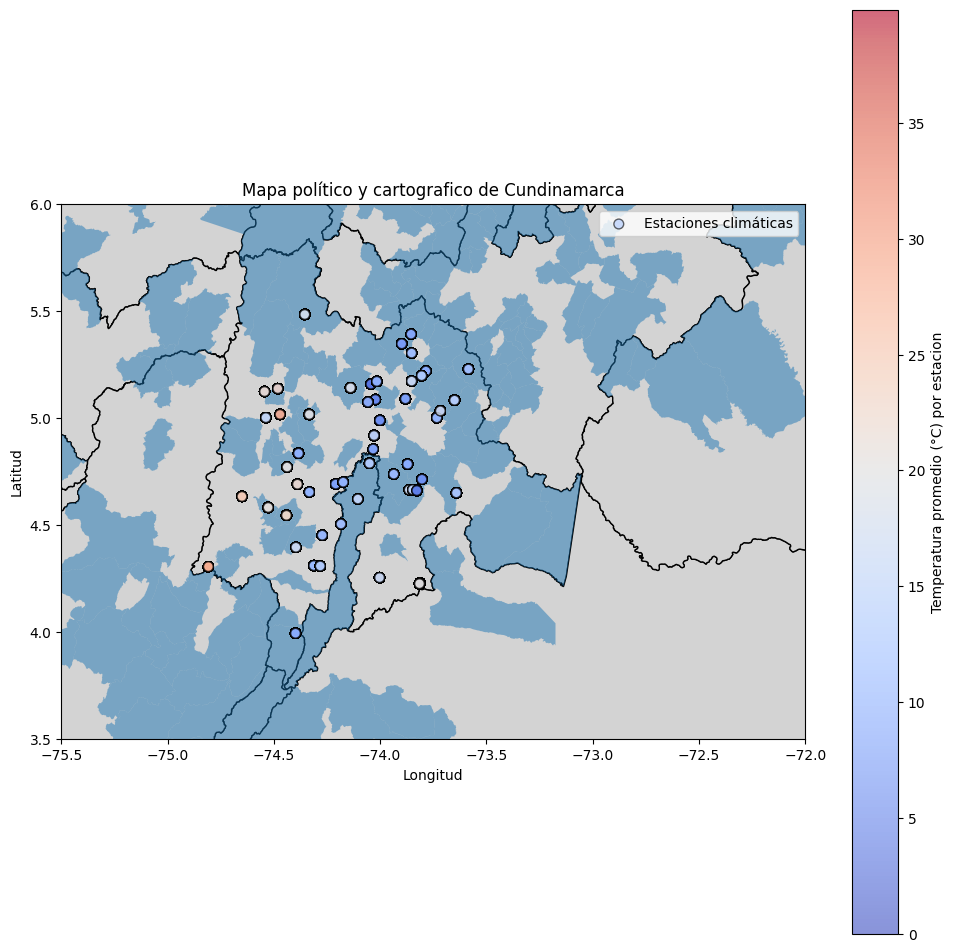

In [16]:

# Reproyectar el cubrimiento de productos del IGAC al EPSG:4686
productos_igac = productos_igac.to_crs(epsg=4686)

# Visualizar el mapa centrado en Cundinamarca
fig, ax = plt.subplots(figsize=(12, 12))
cundinamarca.plot(ax=ax, color='lightgray', edgecolor='black')
productos_igac.plot(ax=ax, alpha=0.5, legend=True)
ax.set_title('Mapa político y cartografico de Cundinamarca')

# Ajustar los límites de los ejes para enfocar en Cundinamarca
ax.set_xlim([-75.5, -72.0])  # Ajustar los límites de longitud
ax.set_ylim([3.5, 6.0])      # Ajustar los límites de latitud

# Asignar colores a los puntos según el promedio de temperatura
sc = ax.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6, label='Estaciones climáticas', edgecolor='black', linewidth=1)

# Ajustar el tamaño de los puntos
sc.set_sizes([50])

# Añadir barra de color
plt.colorbar(sc, label='Temperatura promedio (°C) por estacion')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()
plt.show()


In [11]:
print("hello" 'g'*2)

helloghellog
